In [1]:
import gzip
import math
import matplotlib.pyplot as plt
import numpy
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE

## Bag-of-words models

In [2]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

In [3]:
data = list(parseData("beer_50000.json"))[:5000]

How many unique words are there?

In [5]:
wordCount = defaultdict(int)
for d in data:
    for w in d['review/text'].split():
        wordCount[w] += 1

len(wordCount)

36225

Ignore capitalization and remove punctuation

In [6]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

19426

With stemming

In [7]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1
    
len(wordCount)

14847

Just build our feature vector by taking the most popular words (lowercase, punctuation removed, but no stemming)

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [9]:
words = [x[1] for x in counts[:1000]]


## Sentiment analysis

In [10]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)


In [11]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Extract bag-of-word features. For a bigger dataset, replace this with a sparse matrix to save memory (see examples in Chapter 6)


In [12]:
X = [feature(d) for d in data]
y = [d['review/overall'] for d in data]

In [13]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

## N-grams

In [14]:
sentence = "Dark red color, light beige foam"
unigrams = sentence.split()
bigrams = list(zip(unigrams[:-1], unigrams[1:]))
trigrams = list(zip(unigrams[:-2], unigrams[1:-1], unigrams[2:]))

In [15]:
trigrams

[('Dark', 'red', 'color,'),
 ('red', 'color,', 'light'),
 ('color,', 'light', 'beige'),
 ('light', 'beige', 'foam')]

Extract n-grams up to length 5 (same dataset as example above)

In [16]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [17]:
words = [x[1] for x in counts[:1000]]

A few of our 1000 most popular n-grams. Note the combination of n-grams of different lengths

In [18]:
words[200:210]


['pint',
 'hoppy',
 'stout',
 'though',
 'lots',
 'and the',
 'malty',
 'mouthfeel is',
 'even',
 'quickly']

In [19]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [20]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

Same as the model in the previous example above, except using n-grams rather than just unigrams

In [21]:
X = [feature(d) for d in data]
y = [d['review/overall'] for d in data]

In [22]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [23]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()


In [24]:
wordSort[:20]


[(-0.39143632655627275, 'a lot of'),
 (-0.28212293516961695, 'a bit more'),
 (-0.2661141170411752, 'water'),
 (-0.25302293141505705, 'the background'),
 (-0.24105277280700593, 'corn'),
 (-0.21580888155061675, 'as it warms'),
 (-0.20470888977241958, 'hint of'),
 (-0.20324036428958614, 'yellow'),
 (-0.19776086681453248, 'little more'),
 (-0.19515009289477458, 'watery'),
 (-0.18335494869262023, 'straw'),
 (-0.17846828826404665, 'a hint'),
 (-0.17496287817726044, 'around the'),
 (-0.1738744540908721, 'kind'),
 (-0.1738145913698015, 'down the'),
 (-0.17231514207704576, 'lot'),
 (-0.1688764942448511, 'weak'),
 (-0.16647751584895765, 'bad'),
 (-0.16513650187978737, 'old'),
 (-0.1581538428300227, 'up to')]

In [25]:
wordSort[-20:]


[(0.15966172741191423, 'wonderful'),
 (0.16316670449498694, 'off white head'),
 (0.17379190414371665, 'a little more'),
 (0.17560247184995995, 'favorite'),
 (0.17674628573616427, 'not too'),
 (0.1772497208564457, 'i really'),
 (0.179194864201265, 'easy to'),
 (0.1820091431425593, 'i am'),
 (0.1839456678012328, 'background'),
 (0.18752400440803602, 'touch of'),
 (0.1975181094989651, 'the best'),
 (0.19933817230439202, 'hint'),
 (0.21249123771087114, 'this one is'),
 (0.21410451475827574, 'a hint of'),
 (0.22043777880132126, 'not bad'),
 (0.23768919746951575, 'of these'),
 (0.2387189822002713, 'a bad'),
 (0.24874277211062173, 'lot of'),
 (0.274865347932414, 'a lot'),
 (0.3121741564884012, 'bit more')]

## TF-IDF


In [26]:
dataset = []

In [28]:
z = gzip.open( "goodreads_reviews_fantasy_paranormal.json.gz")
for l in z.readlines():
    dataset.append(eval(l))
    if len(dataset) == 50000:
        break

In [29]:
dataset[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '18245960',
 'review_id': 'dfdbb7b0eb5a7e4c26d59a937e2e5feb',
 'rating': 5,
 'review_text': 'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would 

In [30]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataset:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [31]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [32]:
words = [x[1] for x in counts[:1000]]


## Document frequency (df)


In [33]:
df = defaultdict(int)
for d in dataset:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in set(r.split()):
        df[w] += 1

## Term frequency (tf)

Here we extract frequencies for terms in a single specific review

In [34]:
rev = dataset[9] # Query review
rev

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '76620',
 'review_id': '9206654986a733bd753753aa0c882813',
 'rating': 5,
 'review_text': "I read this after hearing from a few people that it was among their all-time favorites. I was almost put off when I saw it was a story about rabbits, originally written as a tale by a father to his children - but I'm glad I wasn't. \n I found the folk tales about El-ahrairah to be very impressive. The author clearly had a vivid imagination to create so much of the rabbits culture and history. But I think this book was worth reading as it's really a story about survival, leadership, and human nature. \n Oh and Fiver rocks. And BigWig is the man.",
 'date_added': 'Tue Sep 02 17:03:40 -0700 2008',
 'date_updated': 'Wed Dec 14 12:30:43 -0800 2016',
 'read_at': 'Tue May 05 00:00:00 -0700 2015',
 'started_at': 'Sun Apr 19 00:00:00 -0700 2015',
 'n_votes': 30,
 'n_comments': 2}

In [35]:
tf = defaultdict(int)
r = ''.join([c for c in rev['review_text'].lower() if not c in punctuation])
for w in r.split():
    # Note = rather than +=, different versions of tf could be used instead
    tf[w] = 1
    
tfidf = dict(zip(words,[tf[w] * math.log2(len(dataset) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log2(len(dataset) / df[w]) for w in words]


Find the highest tf-idf words in our example review

In [36]:
maxTf = [(tf[w],w) for w in words]
maxTf.sort(reverse=True)
maxTfIdf = [(tfidf[w],w) for w in words]
maxTfIdf.sort(reverse=True)

In [37]:
maxTfIdf[:10]


[(6.475214154215886, 'nature'),
 (6.1604918290613755, 'tales'),
 (5.77675046027207, 'children'),
 (5.7117950184313, 'saw'),
 (5.316168825598678, 'history'),
 (5.286585714095165, 'father'),
 (4.98210658996402, 'worth'),
 (4.910068021149542, 'glad'),
 (4.881720019873613, 'human'),
 (4.731589561708275, 'tale')]

In [38]:
def Cosine(x1,x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

Find the other reviews in the corpus with the highest cosine similarity between tf-idf vectors

In [39]:
similarities = []
for rev2 in dataset:
    tf = defaultdict(int)
    r = ''.join([c for c in rev2['review_text'].lower() if not c in punctuation])
    for w in r.split():
        # Note = rather than +=
        tf[w] = 1
    tfidf2 = [tf[w] * math.log2(len(dataset) / df[w]) for w in words]
    similarities.append((Cosine(tfidfQuery, tfidf2), rev2['review_text']))


In [40]:
similarities.sort(reverse=True)

In [41]:
similarities[:10]


[(1.0,
  "I read this after hearing from a few people that it was among their all-time favorites. I was almost put off when I saw it was a story about rabbits, originally written as a tale by a father to his children - but I'm glad I wasn't. \n I found the folk tales about El-ahrairah to be very impressive. The author clearly had a vivid imagination to create so much of the rabbits culture and history. But I think this book was worth reading as it's really a story about survival, leadership, and human nature. \n Oh and Fiver rocks. And BigWig is the man."),
 (0.33623828530476574,
  'Need a review \n For a full explanation of the provenance and history of Arabian Nights, as well as an alternative translation, see \n https://www.theatlantic.com/entertain... \n For children, see \n Aladdin and Other Tales from the Arabian Nights, Dawood, 1960 \n https://www.goodreads.com/review/show...'),
 (0.2944751254505903,
  'Awesome! Love this author and his story world. Found quite a few errors/typo

## word2vec (gensim)

A few utility data structures (used later)

In [42]:
beerStyles = {} # Style of each item
categories = set() # Set of item categories
reviewsPerUser = defaultdict(list)
beerIdToName = {} # Map an ID to the name of the product

In [44]:
z = open( "beer_50000.json")

reviews = []
reviewDicts = []

for l in z:
    d = eval(l)
    reviews.append(d['review/text'])
    beerStyles[d['beer/beerId']] = d['beer/style']
    categories.add(d['beer/style'])
    beerIdToName[d['beer/beerId']] = d['beer/name']
    reviewsPerUser[d['user/profileName']].append((d['review/timeUnix'], d['beer/beerId']))
    reviewDicts.append(d)
    if len(reviews) == 50000:
        break

Tokenize the reviews, so that each review becomes a list of words

In [45]:
reviewTokens = []


In [46]:
punctuation = set(string.punctuation)
for r in reviews:
    r = ''.join([c for c in r.lower() if not c in punctuation])
    tokens = []
    for w in r.split():
        tokens.append(w)
    reviewTokens.append(tokens)


In [47]:
reviewTokens[0]



['a',
 'lot',
 'of',
 'foam',
 'but',
 'a',
 'lot',
 'in',
 'the',
 'smell',
 'some',
 'banana',
 'and',
 'then',
 'lactic',
 'and',
 'tart',
 'not',
 'a',
 'good',
 'start',
 'quite',
 'dark',
 'orange',
 'in',
 'color',
 'with',
 'a',
 'lively',
 'carbonation',
 'now',
 'visible',
 'under',
 'the',
 'foam',
 'again',
 'tending',
 'to',
 'lactic',
 'sourness',
 'same',
 'for',
 'the',
 'taste',
 'with',
 'some',
 'yeast',
 'and',
 'banana']

Fit the word2vec model

In [49]:
model = Word2Vec(
    reviewTokens,
    min_count=5,  # Words/items with fewer instances are discarded
    vector_size=10,  # Model dimensionality
    window=3,  # Window size
    sg=1  # Skip-gram model
)


Extract word representation for a particular word

In [51]:
model.wv['yeast']

array([-0.12109948,  0.4678515 , -0.34363437,  0.9776479 ,  0.4117113 ,
        0.11399045,  0.9772307 , -0.03496059, -1.2417806 , -0.44002807],
      dtype=float32)

Find similar words to a given query

In [52]:
model.wv.similar_by_word("grassy")

[('flowery', 0.9889405965805054),
 ('floral', 0.9877688884735107),
 ('piny', 0.9863861203193665),
 ('citrus', 0.9849520325660706),
 ('citric', 0.9843518137931824),
 ('spicy', 0.9776545166969299),
 ('herbal', 0.9756908416748047),
 ('perfumey', 0.9743500351905823),
 ('earthy', 0.9742292761802673),
 ('piney', 0.9731622338294983)]

## item2vec

Almost the same as word2vec, but "documents" are made up of sequences of item IDs rather than words



In [53]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])

In [54]:
model10 = Word2Vec(reviewLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [55]:
beerIdToName['7360']


'Crystal Bitter Ale'

In [56]:
model10.wv.similar_by_word('7360')


[('12982', 0.9878674149513245),
 ('32374', 0.9873347878456116),
 ('53677', 0.9835060834884644),
 ('64727', 0.9828454256057739),
 ('24989', 0.9823707342147827),
 ('52159', 0.9814691543579102),
 ('66433', 0.9813783168792725),
 ('32710', 0.9812657237052917),
 ('14301', 0.981135368347168),
 ('3804', 0.9808192253112793)]

In [57]:
for b in model10.wv.similar_by_word('7360'):
    print(beerIdToName[b[0]])


Triple
Puget Sound Vanilla Porter
British Pale Ale
Winterfest
Auld Acquaintance IPA
Caldera Ginger Beer
Patrick's Pick Extra Special Bitter
Strawberry Anti-Social
Dark Mild
Latter Days Stout


## t-SNE embedding

Visualize the embeddings from the model above using t-SNE

In [65]:
import numpy as np

X = []  # Initialize as a list
beers = []

for b in beerIdToName:
    try:
        # Add the word vector representation of 'b' to X
        X.append(list(model10.wv[b]))  # Assuming `b` exists in `model10.wv`
        beers.append(b)
    except Exception as e:
        pass

# Convert X to a NumPy array after appending all the vectors
X = np.array(X)

print(X.shape[0])  # This should now print the correct number of samples


658


Fit a model with just two components for the sake of visualization

In [66]:
X_embedded = TSNE(n_components=2).fit_transform(X)

Generate scatterplots using the embedded points (one scatter plot per category)

In [67]:
scatterPlotsX = defaultdict(list)
scatterPlotsY = defaultdict(list)
for xy, b in zip(X, beers):
    cat = beerStyles[b]
    try:
        scatterPlotsX[cat].append(xy[0])
        scatterPlotsY[cat].append(xy[1])
    except Exception as e:
        pass

Plot data from a few categories (more interesting with a larger dataset)

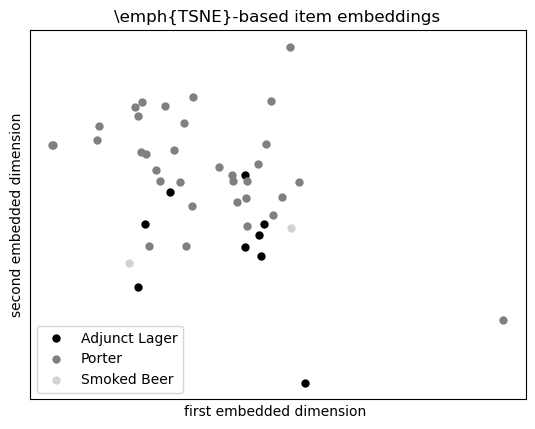

In [68]:
plt.scatter(scatterPlotsX['American Adjunct Lager'],
            scatterPlotsY['American Adjunct Lager'], color='k', lw=0, label="Adjunct Lager")
plt.scatter(scatterPlotsX['American Porter'],
            scatterPlotsY['American Porter'], color='grey', lw=0, label = "Porter")
plt.scatter(scatterPlotsX['Smoked Beer'],
            scatterPlotsY['Smoked Beer'], color='lightgrey', lw = 0, label = "Smoked Beer")
plt.legend(loc='lower left')
plt.xticks([])
plt.yticks([])
plt.xlabel("first embedded dimension ")
plt.ylabel("second embedded dimension")
plt.title("\emph{TSNE}-based item embeddings")
plt.show()